## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("shot_logs.csv")

In [3]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


## Data Cleaning

In [4]:
df.dtypes

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object

#### Fixing and dropping features

##### Matchup gives an idea about the date and teams. These are not relevant for a player, so dropping this.

In [5]:
df.MATCHUP

0         MAR 04, 2015 - CHA @ BKN
1         MAR 04, 2015 - CHA @ BKN
2         MAR 04, 2015 - CHA @ BKN
3         MAR 04, 2015 - CHA @ BKN
4         MAR 04, 2015 - CHA @ BKN
                    ...           
128064    OCT 29, 2014 - BKN @ BOS
128065    OCT 29, 2014 - BKN @ BOS
128066    OCT 29, 2014 - BKN @ BOS
128067    OCT 29, 2014 - BKN @ BOS
128068    OCT 29, 2014 - BKN @ BOS
Name: MATCHUP, Length: 128069, dtype: object

In [6]:
df = df.drop(['MATCHUP'], axis = 1)

##### Location, whether the team is home team or an away team, irrelevant so dropping this.

In [7]:
df.LOCATION

0         A
1         A
2         A
3         A
4         A
         ..
128064    A
128065    A
128066    A
128067    A
128068    A
Name: LOCATION, Length: 128069, dtype: object

In [8]:
df = df.drop(['LOCATION'], axis = 1)

##### Gives the same information as the FGM, drop this feature

In [9]:
df = df.drop(['W'], axis = 1)

In [10]:
df = df.drop(['SHOT_NUMBER'], axis = 1)

###### Formatting of time is inappropriate for using, convert this to amount of seconds left in a period

In [11]:
df.GAME_CLOCK

0          1:09
1          0:14
2          0:00
3         11:47
4         10:34
          ...  
128064     1:52
128065    11:28
128066    11:10
128067     2:37
128068     0:12
Name: GAME_CLOCK, Length: 128069, dtype: object

In [12]:
df['SECONDS_LEFT_IN_PERIOD'] = df['GAME_CLOCK'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [13]:
df = df.drop(['GAME_CLOCK'], axis = 1)

##### Fix negative touch time

In [14]:
df = df[df['TOUCH_TIME'] >= 0]

##### Shot result gives same information as the FGM, so drop this feature

In [15]:
df = df.drop(['SHOT_RESULT'], axis = 1)

##### Dropping type of points

In [16]:
df = df.drop(['PTS'], axis = 1)

In [17]:
df

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,player_name,player_id,SECONDS_LEFT_IN_PERIOD
0,21400899,24,1,10.8,2,1.9,7.7,2,"Anderson, Alan",101187,1.3,1,brian roberts,203148,69
1,21400899,24,1,3.4,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,6.1,0,brian roberts,203148,14
2,21400899,24,1,NaN,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,0.9,0,brian roberts,203148,0
3,21400899,24,2,10.3,2,1.9,17.2,2,"Brown, Markel",203900,3.4,0,brian roberts,203148,707
4,21400899,24,2,10.9,2,2.7,3.7,2,"Young, Thaddeus",201152,1.1,0,brian roberts,203148,634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,-16,3,18.3,5,6.2,8.7,2,"Smart, Marcus",203935,0.8,0,jarrett jack,101127,112
128065,21400006,-16,4,19.8,4,5.2,0.6,2,"Turner, Evan",202323,0.6,1,jarrett jack,101127,688
128066,21400006,-16,4,23.0,2,4.2,16.9,2,"Thornton, Marcus",201977,4.2,1,jarrett jack,101127,670
128067,21400006,-16,4,9.1,4,4.5,18.3,2,"Bradley, Avery",202340,3.0,0,jarrett jack,101127,157


In [18]:
df.isna().any()

GAME_ID                       False
FINAL_MARGIN                  False
PERIOD                        False
SHOT_CLOCK                     True
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
player_name                   False
player_id                     False
SECONDS_LEFT_IN_PERIOD        False
dtype: bool

In [19]:
df["SHOT_CLOCK"].fillna(df["SHOT_CLOCK"].mean(), inplace=True)

In [20]:
defenders = df[['CLOSEST_DEFENDER_PLAYER_ID', 'CLOSEST_DEFENDER']]

In [21]:
defenders

,CLOSEST_DEFENDER_PLAYER_ID,CLOSEST_DEFENDER
0,101187,"Anderson, Alan"
1,202711,"Bogdanovic, Bojan"
2,202711,"Bogdanovic, Bojan"
3,203900,"Brown, Markel"
4,201152,"Young, Thaddeus"
...,...,...
128064,203935,"Smart, Marcus"
128065,202323,"Turner, Evan"
128066,201977,"Thornton, Marcus"
128067,202340,"Bradley, Avery"


### Exploring data for extracting more relevant information

Just knowing the closest defender is not a useful feature, so improving on available features. Finding the blocking efficiency of the defender. Also, using the information of efficiency with count of blocked shots, and attempted shots, a ranking for the defenders is obtained. 

In [22]:
df['CLOSEST_DEFENDER_EFFICIENCY'] = [0.0] * len(df)

for defender_id in df['CLOSEST_DEFENDER_PLAYER_ID']:
    temp_df = df[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id]
    temp_eff = (temp_df['FGM'] == 0).sum() / temp_df['FGM'].count()
    df.loc[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id, 'CLOSEST_DEFENDER_EFFICIENCY'] = temp_eff
    
    blockedShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id) & (df['FGM'] == 0)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    allShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKING_EFFICIENCY'] = blockedShots/allShots


C:\Users\madha\AppData\Local\Temp\ipykernel_20776\2737887701.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
C:\Users\madha\AppData\Local\Temp\ipykernel_20776\2737887701.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
C:\Users\madha\AppData\Local\Temp\ipykernel_20776\2737887701.py:12: SettingWithCopyW

In [23]:
defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

C:\Users\madha\AppData\Local\Temp\ipykernel_20776\3135344425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)


In [24]:
defenders

,CLOSEST_DEFENDER_PLAYER_ID,CLOSEST_DEFENDER,BLOCKED_SHOTS,ALL_SHOTS,BLOCKING_EFFICIENCY,CLOSEST_DEFENDER_RANK
0,101187,"Anderson, Alan",209.0,382.0,0.547120,135
1,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
2,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
3,203900,"Brown, Markel",27.0,50.0,0.540000,388
4,201152,"Young, Thaddeus",275.0,531.0,0.517891,56
...,...,...,...,...,...,...
128064,203935,"Smart, Marcus",163.0,294.0,0.554422,203
128065,202323,"Turner, Evan",292.0,497.0,0.587525,77
128066,201977,"Thornton, Marcus",71.0,127.0,0.559055,327
128067,202340,"Bradley, Avery",247.0,448.0,0.551339,105


In [25]:
df

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,player_name,player_id,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY
0,21400899,24,1,10.800000,2,1.9,7.7,2,"Anderson, Alan",101187,1.3,1,brian roberts,203148,69,0.547120
1,21400899,24,1,3.400000,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,6.1,0,brian roberts,203148,14,0.592476
2,21400899,24,1,12.450301,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,0.9,0,brian roberts,203148,0,0.592476
3,21400899,24,2,10.300000,2,1.9,17.2,2,"Brown, Markel",203900,3.4,0,brian roberts,203148,707,0.540000
4,21400899,24,2,10.900000,2,2.7,3.7,2,"Young, Thaddeus",201152,1.1,0,brian roberts,203148,634,0.517891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,-16,3,18.300000,5,6.2,8.7,2,"Smart, Marcus",203935,0.8,0,jarrett jack,101127,112,0.554422
128065,21400006,-16,4,19.800000,4,5.2,0.6,2,"Turner, Evan",202323,0.6,1,jarrett jack,101127,688,0.587525
128066,21400006,-16,4,23.000000,2,4.2,16.9,2,"Thornton, Marcus",201977,4.2,1,jarrett jack,101127,670,0.559055
128067,21400006,-16,4,9.100000,4,4.5,18.3,2,"Bradley, Avery",202340,3.0,0,jarrett jack,101127,157,0.551339


In [26]:
df.describe()

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,player_id,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY
count,1.277570e+05,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000
mean,2.140045e+07,0.209789,2.469595,12.450301,2.02828,2.778727,13.576808,2.264964,159043.963399,4.124012,0.452468,157229.09032,351.409011,0.547532
std,2.578955e+02,13.235094,1.139929,5.629991,3.48057,2.987196,8.887801,0.441316,78788.073182,2.756188,0.497738,79369.28322,207.602250,0.038680
min,2.140000e+07,-53.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,708.00000,0.000000,0.000000
25%,2.140023e+07,-8.000000,1.000000,8.400000,0.00000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,101162.00000,172.000000,0.524064
50%,2.140045e+07,1.000000,2.000000,12.450301,1.00000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,201939.00000,352.000000,0.547059
75%,2.140067e+07,9.000000,3.000000,16.400000,2.00000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,202704.00000,531.000000,0.569472
max,2.140091e+07,53.000000,7.000000,24.000000,32.00000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,204060.00000,720.000000,1.000000


In [224]:
players_data = df[['player_name', 'player_id']]
players_data = players_data.drop_duplicates()
players_data = players_data.reset_index()

In [225]:
#Shot distance
shotDist = df.groupby('player_name')['SHOT_DIST'].mean()
shotDist = shotDist.reset_index()
shotDist.columns = ['player_name', 'shot_distance']
players_data['shot_distance'] = shotDist['shot_distance']

In [226]:
#Shot distance
secLeft = df.groupby('player_name')['SECONDS_LEFT_IN_PERIOD'].mean()
secLeft = secLeft.reset_index()
secLeft.columns = ['player_name', 'SECONDS_LEFT_IN_PERIOD']
players_data['SECONDS_LEFT_IN_PERIOD'] = secLeft['SECONDS_LEFT_IN_PERIOD']

In [227]:
#Shot distance
defEff = df.groupby('player_name')['CLOSEST_DEFENDER_EFFICIENCY'].mean()
defEff = defEff.reset_index()
defEff.columns = ['player_name', 'CLOSEST_DEFENDER_EFFICIENCY']
players_data['CLOSEST_DEFENDER_EFFICIENCY'] = defEff['CLOSEST_DEFENDER_EFFICIENCY']

In [228]:
#Shot distance
shotClk = df.groupby('player_name')['SHOT_CLOCK'].mean()
shotClk = shotClk.reset_index()
shotClk.columns = ['player_name', 'SHOT_CLOCK']
players_data['SHOT_CLOCK'] = shotClk['SHOT_CLOCK']

In [229]:
#Shot distance
defDist = df.groupby('player_name')['CLOSE_DEF_DIST'].mean()
defDist = defDist.reset_index()
defDist.columns = ['player_name', 'CLOSE_DEF_DIST']
players_data['CLOSE_DEF_DIST'] = defDist['CLOSE_DEF_DIST'] 

In [230]:
#Shot distance
tt = df.groupby('player_name')['TOUCH_TIME'].mean()
tt = tt.reset_index()
tt.columns = ['player_name', 'TOUCH_TIME']
players_data['TOUCH_TIME'] = tt['TOUCH_TIME'] 

In [231]:
#Shot distance
prd = df.groupby('player_name')['PERIOD'].mean()
prd = prd.reset_index()
prd.columns = ['player_name', 'PERIOD']
players_data['PERIOD'] = prd['PERIOD'] 

In [232]:
#Shot distance
drb = df.groupby('player_name')['DRIBBLES'].mean()
drb = drb.reset_index()
drb.columns = ['player_name', 'DRIBBLES']
players_data['DRIBBLES'] = drb['DRIBBLES'] 

In [233]:
#Attempted Shots
attempted = df.groupby('player_name')['FGM'].count()
attempted = attempted.reset_index()
attempted.columns = ['player_name', 'ATTEMPTED_SHOTS']
players_data['ATTEMPTED_SHOTS'] = attempted['ATTEMPTED_SHOTS'] 

In [234]:
#Successful Shots
baskets = df.groupby('player_name')[['FGM']].sum()
baskets = baskets.reset_index()
baskets.columns = ['player_name', 'SUCCESSFUL_SHOTS']
players_data['SUCCESSFUL_SHOTS'] = baskets['SUCCESSFUL_SHOTS'] 

In [235]:
#Shooting Accuracy
shootAcc = baskets['SUCCESSFUL_SHOTS']/attempted['ATTEMPTED_SHOTS']
shootAcc = shootAcc.reset_index()
shootAcc.columns = ['INDEX', 'SHOOTING_ACCURACY']
players_data['SHOOTING_ACCURACY'] = shootAcc['SHOOTING_ACCURACY'] 

In [236]:
players_data

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY
0,0,brian roberts,203148,15.055635,356.928444,0.551191,11.879179,3.662791,4.977996,2.826476,5.422182,559,232,0.415027
1,372,bismack biyombo,202687,10.062500,376.730769,0.540020,12.943281,4.152885,2.068269,2.288462,1.355769,104,55,0.528846
2,486,al jefferson,2744,12.893411,339.279070,0.543273,13.323462,4.972093,1.401163,2.465116,0.515504,258,111,0.430233
3,1286,cody zeller,203469,11.989201,423.242637,0.541412,11.766145,4.889201,1.814867,2.527349,0.538569,713,386,0.541374
4,1641,gary neal,202390,9.340881,353.192453,0.542361,10.596858,3.036855,2.658239,2.440252,0.700629,795,380,0.477987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,125727,deron williams,101114,18.522193,389.826203,0.553939,12.514318,4.870187,2.124465,2.594920,1.179144,748,336,0.449198
277,126242,joe johnson,2207,15.371214,368.956344,0.550207,12.925592,4.066166,2.363847,2.330150,1.499318,733,304,0.414734
278,127009,jerome jordan,202366,14.776011,336.862534,0.555221,12.771985,4.146631,4.217251,2.649596,3.967655,371,157,0.423181
279,127097,bojan bogdanovic,202711,8.205997,326.401799,0.542076,11.715611,2.955172,2.361469,2.410795,0.848576,667,327,0.490255


In [237]:
df

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,player_name,player_id,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY
0,21400899,24,1,10.800000,2,1.9,7.7,2,"Anderson, Alan",101187,1.3,1,brian roberts,203148,69,0.547120
1,21400899,24,1,3.400000,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,6.1,0,brian roberts,203148,14,0.592476
2,21400899,24,1,12.450301,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,0.9,0,brian roberts,203148,0,0.592476
3,21400899,24,2,10.300000,2,1.9,17.2,2,"Brown, Markel",203900,3.4,0,brian roberts,203148,707,0.540000
4,21400899,24,2,10.900000,2,2.7,3.7,2,"Young, Thaddeus",201152,1.1,0,brian roberts,203148,634,0.517891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,-16,3,18.300000,5,6.2,8.7,2,"Smart, Marcus",203935,0.8,0,jarrett jack,101127,112,0.554422
128065,21400006,-16,4,19.800000,4,5.2,0.6,2,"Turner, Evan",202323,0.6,1,jarrett jack,101127,688,0.587525
128066,21400006,-16,4,23.000000,2,4.2,16.9,2,"Thornton, Marcus",201977,4.2,1,jarrett jack,101127,670,0.559055
128067,21400006,-16,4,9.100000,4,4.5,18.3,2,"Bradley, Avery",202340,3.0,0,jarrett jack,101127,157,0.551339


<Axes: xlabel='PERIOD', ylabel='Count'>

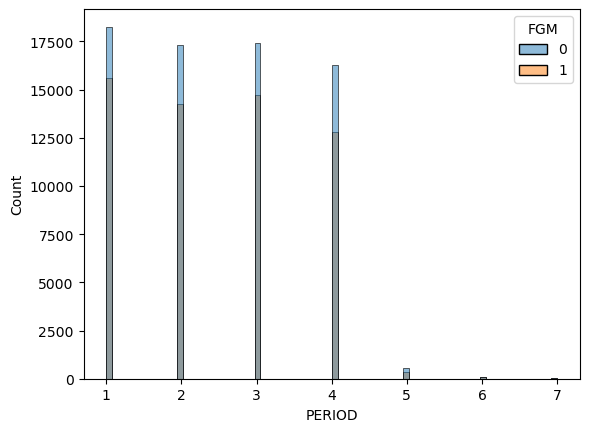

In [238]:
sns.histplot(df, x="PERIOD", hue="FGM", element="bars")

<Axes: xlabel='SHOT_CLOCK', ylabel='Count'>

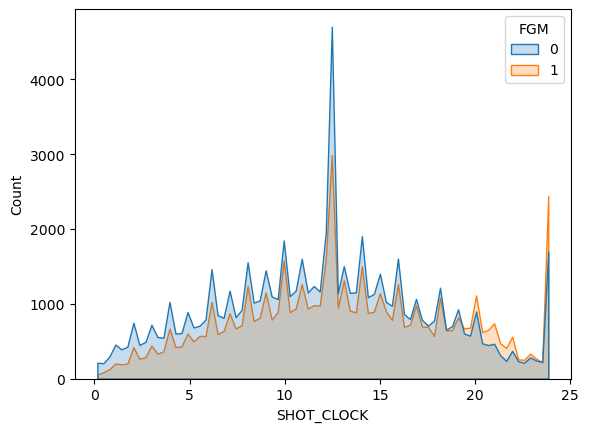

In [239]:
sns.histplot(df, x="SHOT_CLOCK", hue="FGM", element="poly")

<Axes: xlabel='DRIBBLES', ylabel='count'>

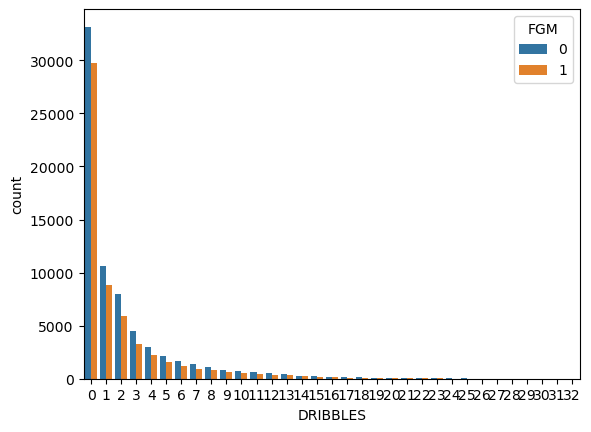

In [240]:
sns.countplot(data=df, x='DRIBBLES', hue='FGM')

<Axes: xlabel='TOUCH_TIME', ylabel='Count'>

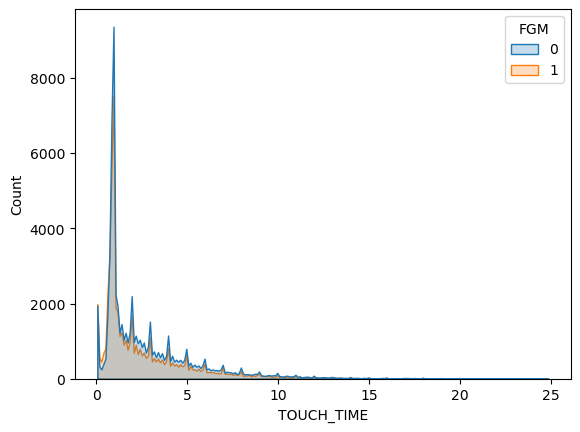

In [241]:
sns.histplot(df, x="TOUCH_TIME", hue="FGM", element="poly")

<Axes: xlabel='SHOT_DIST', ylabel='Count'>

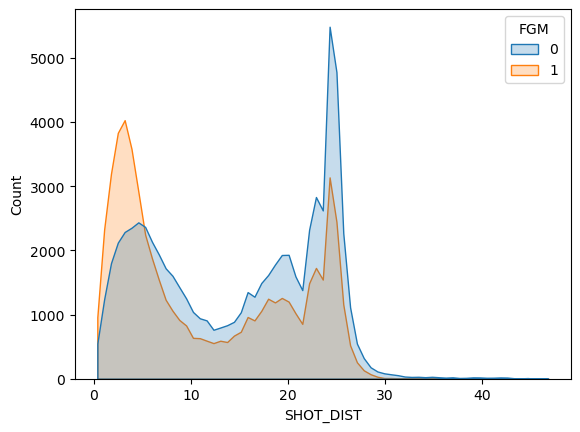

In [242]:
sns.histplot(df, x="SHOT_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSE_DEF_DIST', ylabel='Count'>

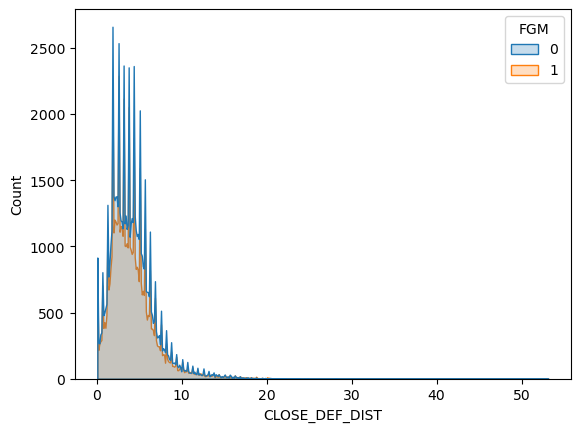

In [243]:
sns.histplot(df, x="CLOSE_DEF_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSEST_DEFENDER_EFFICIENCY', ylabel='Count'>

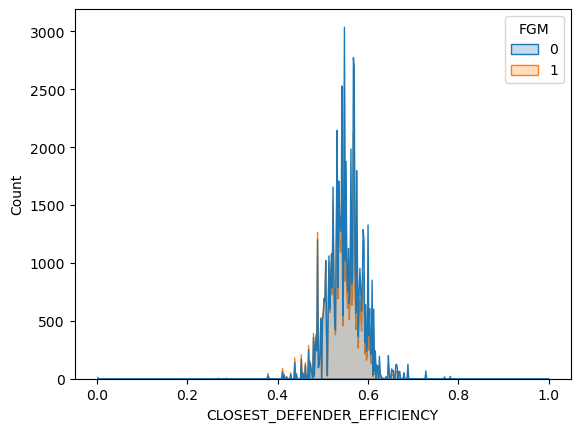

In [244]:
sns.histplot(df, x="CLOSEST_DEFENDER_EFFICIENCY", hue="FGM", element="poly")

<Axes: xlabel='SECONDS_LEFT_IN_PERIOD', ylabel='Count'>

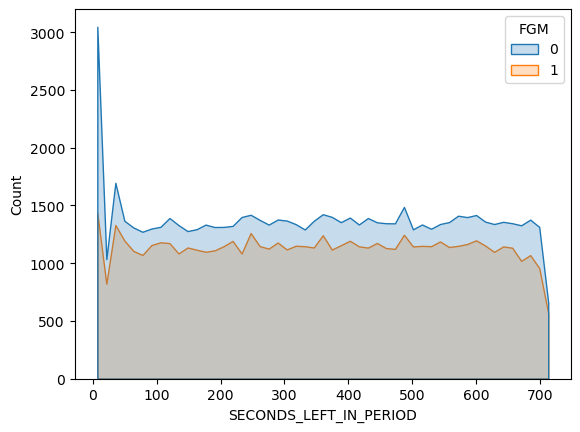

In [245]:
sns.histplot(df, x="SECONDS_LEFT_IN_PERIOD", hue="FGM", element="poly")

### Finding correlation between features

In [246]:
selected_features = df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY','SECONDS_LEFT_IN_PERIOD','FGM']].copy()

<Axes: >

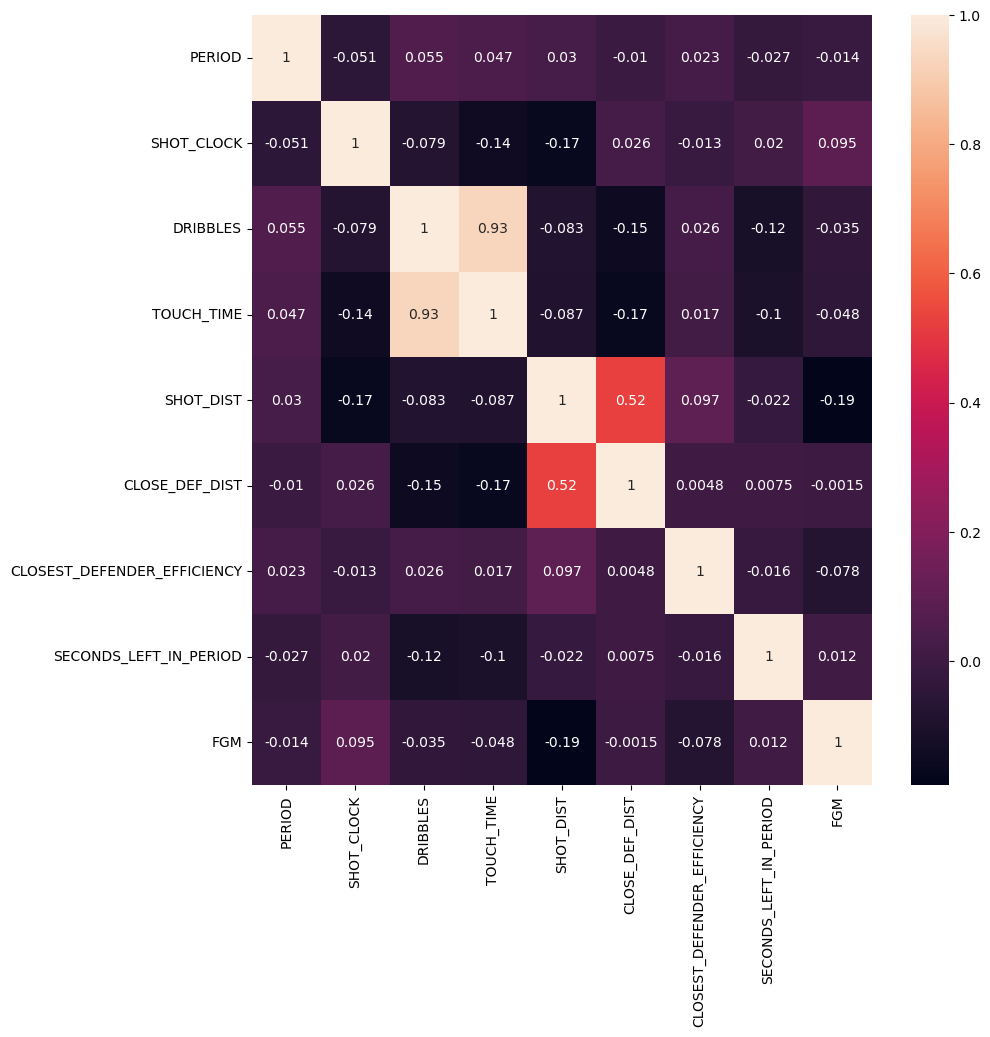

In [247]:
corr = selected_features.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True)

### Predicting shot output

In [248]:
X = selected_features.drop('FGM', axis = 1)
y = selected_features['FGM']

C:\Users\madha\AppData\Local\Temp\ipykernel_20776\476133659.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: xlabel='FGM', ylabel='Density'>

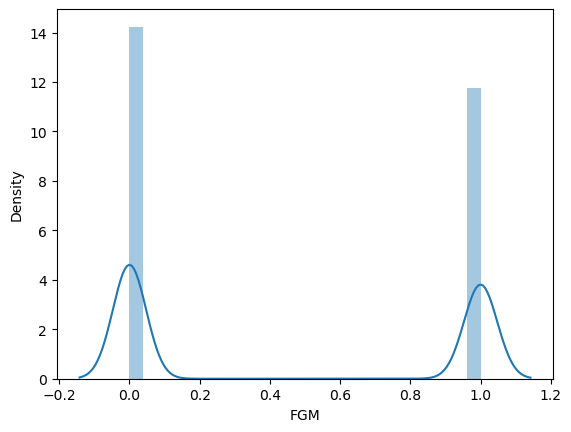

In [249]:
sns.distplot(y)

In [250]:
from sklearn.tree import DecisionTreeClassifier

In [251]:
X_DT = selected_features.drop('FGM', axis = 1)
y_DT = selected_features['FGM']
X_DT_train, X_DT_val, y_DT_train, y_DT_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [252]:
modelDT = DecisionTreeClassifier(random_state=0)
modelDT.fit(X_DT_train, y_DT_train)

DecisionTreeClassifier(random_state=0)

In [253]:
y_DT_pred = modelDT.predict(X_DT_val)

In [254]:
from sklearn.metrics import accuracy_score
accuracyDT = accuracy_score(y_DT_val, y_DT_pred)
print("Accuracy: {:.2f}%".format(accuracyDT * 100))

Accuracy: 53.90%


### Logistic Regression

In [255]:
from sklearn.linear_model import LogisticRegression

In [256]:
X_LR = selected_features.drop('FGM', axis = 1)
y_LR = selected_features['FGM']
X_LR_train, X_LR_val, y_LR_train, y_LR_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [257]:
modelLR = LogisticRegression(max_iter=1000)
modelLR.fit(X_LR_train, y_LR_train)

LogisticRegression(max_iter=1000)

In [258]:
y_LR_pred = modelLR.predict(X_LR_val)

In [259]:
# DT_acc = classification_report(y0_test, y0_pred, output_dict = True)
# print(DT_acc['accuracy'])

from sklearn.metrics import accuracy_score
accuracyLR = accuracy_score(y_LR_val, y_LR_pred)
print("Accuracy: {:.2f}%".format(accuracyLR * 100))

Accuracy: 61.12%


### K Nearest Neighbors

In [260]:
from sklearn.neighbors import KNeighborsClassifier

In [261]:
X_KNN = selected_features.drop('FGM', axis = 1)
y_KNN = selected_features['FGM']
X_KNN_train, X_KNN_val, y_KNN_train, y_KNN_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [262]:
modelKNN = KNeighborsClassifier()
modelKNN.fit(X_KNN_train, y_KNN_train)

KNeighborsClassifier()

In [263]:
y_KNN_pred = modelKNN.predict(X_KNN_val)

In [264]:
# DT_acc = classification_report(y0_test, y0_pred, output_dict = True)
# print(DT_acc['accuracy'])

from sklearn.metrics import accuracy_score
accuracyKNN = accuracy_score(y_KNN_val, y_KNN_pred)
print("Accuracy: {:.2f}%".format(accuracyKNN * 100))

Accuracy: 55.75%


### Naive Bayes

In [265]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [266]:
X_NB = selected_features.drop('FGM', axis = 1)
y_NB = selected_features['FGM']
X_NB_train, X_NB_val, y_NB_train, y_NB_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [267]:
modelNB = GaussianNB()
modelNB.fit(X_NB_train, y_NB_train)

GaussianNB()

In [268]:
y_NB_pred = modelNB.predict(X_NB_val)

In [269]:
# DT_acc = classification_report(y0_test, y0_pred, output_dict = True)
# print(DT_acc['accuracy'])

from sklearn.metrics import accuracy_score
accuracyNB = accuracy_score(y_NB_val, y_NB_pred)
print("Accuracy: {:.2f}%".format(accuracyNB * 100))

Accuracy: 59.47%


### SVM

In [270]:
from sklearn.linear_model import SGDClassifier


In [271]:
X_SGD = selected_features.drop('FGM', axis = 1)
y_SGD = selected_features['FGM']
X_SGD_train, X_SGD_val, y_SGD_train, y_SGD_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [272]:
modelSGD = SGDClassifier()
modelSGD.fit(X_SGD_train, y_SGD_train)

SGDClassifier()

In [273]:
y_SGD_pred = modelSGD.predict(X_SGD_val)

In [274]:
# DT_acc = classification_report(y0_test, y0_pred, output_dict = True)
# print(DT_acc['accuracy'])

from sklearn.metrics import accuracy_score
accuracySGD = accuracy_score(y_SGD_val, y_SGD_pred)
print("Accuracy: {:.2f}%".format(accuracySGD * 100))

Accuracy: 55.50%


from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_DT_val, predictionsDT)
plt.figure()
sns.heatmap(cf, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

#### Using the Best Classifier get feature importance

In [275]:
accuracies = pd.DataFrame({'Approach': ['Decision Tree', 'Logistic Regression', 'K Nearest Neighbors', 'Naive Bayes' ,'SGD'], 'Accuracy': [accuracyDT*100, accuracyLR*100, accuracyKNN*100, accuracyNB*100, accuracySGD*100]})

In [276]:
accuracies.sort_values(by = 'Accuracy', ascending = False)

,Approach,Accuracy
1,Logistic Regression,61.118503
3,Naive Bayes,59.474796
2,K Nearest Neighbors,55.745147
4,SGD,55.502505
0,Decision Tree,53.897934


In [277]:
importance = modelLR.coef_[0]

In [278]:
impt = pd.DataFrame({"Features": X.columns, "Feature_Importance": importance})
impt = impt.sort_values(by = 'Feature_Importance', ascending = False)
print(impt)

                      Features  Feature_Importance
5               CLOSE_DEF_DIST            0.104675
2                     DRIBBLES            0.021945
1                   SHOT_CLOCK            0.018133
0                       PERIOD            0.008611
7       SECONDS_LEFT_IN_PERIOD            0.000053
6  CLOSEST_DEFENDER_EFFICIENCY           -0.002895
3                   TOUCH_TIME           -0.052120
4                    SHOT_DIST           -0.060243


In [279]:
periodImpt = impt[impt.Features == 'PERIOD'].Feature_Importance
shotClkImpt = impt[impt.Features == 'SHOT_CLOCK'].Feature_Importance
dribblesImpt = impt[impt.Features == 'DRIBBLES'].Feature_Importance
ttImpt = impt[impt.Features == 'TOUCH_TIME'].Feature_Importance
shotDistImpt = impt[impt.Features == 'SHOT_DIST'].Feature_Importance
closeDefDistImpt = impt[impt.Features == 'CLOSE_DEF_DIST'].Feature_Importance
closeDefEffImpt = impt[impt.Features == 'CLOSEST_DEFENDER_EFFICIENCY'].Feature_Importance
secLeftImpt = impt[impt.Features == 'SECONDS_LEFT_IN_PERIOD'].Feature_Importance


In [280]:
df.describe()

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,player_id,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY
count,1.277570e+05,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000
mean,2.140045e+07,0.209789,2.469595,12.450301,2.02828,2.778727,13.576808,2.264964,159043.963399,4.124012,0.452468,157229.09032,351.409011,0.547532
std,2.578955e+02,13.235094,1.139929,5.629991,3.48057,2.987196,8.887801,0.441316,78788.073182,2.756188,0.497738,79369.28322,207.602250,0.038680
min,2.140000e+07,-53.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,708.00000,0.000000,0.000000
25%,2.140023e+07,-8.000000,1.000000,8.400000,0.00000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,101162.00000,172.000000,0.524064
50%,2.140045e+07,1.000000,2.000000,12.450301,1.00000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,201939.00000,352.000000,0.547059
75%,2.140067e+07,9.000000,3.000000,16.400000,2.00000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,202704.00000,531.000000,0.569472
max,2.140091e+07,53.000000,7.000000,24.000000,32.00000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,204060.00000,720.000000,1.000000


In [282]:
players_data

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY
0,0,brian roberts,203148,15.055635,356.928444,0.551191,11.879179,3.662791,4.977996,2.826476,5.422182,559,232,0.415027
1,372,bismack biyombo,202687,10.062500,376.730769,0.540020,12.943281,4.152885,2.068269,2.288462,1.355769,104,55,0.528846
2,486,al jefferson,2744,12.893411,339.279070,0.543273,13.323462,4.972093,1.401163,2.465116,0.515504,258,111,0.430233
3,1286,cody zeller,203469,11.989201,423.242637,0.541412,11.766145,4.889201,1.814867,2.527349,0.538569,713,386,0.541374
4,1641,gary neal,202390,9.340881,353.192453,0.542361,10.596858,3.036855,2.658239,2.440252,0.700629,795,380,0.477987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,125727,deron williams,101114,18.522193,389.826203,0.553939,12.514318,4.870187,2.124465,2.594920,1.179144,748,336,0.449198
277,126242,joe johnson,2207,15.371214,368.956344,0.550207,12.925592,4.066166,2.363847,2.330150,1.499318,733,304,0.414734
278,127009,jerome jordan,202366,14.776011,336.862534,0.555221,12.771985,4.146631,4.217251,2.649596,3.967655,371,157,0.423181
279,127097,bojan bogdanovic,202711,8.205997,326.401799,0.542076,11.715611,2.955172,2.361469,2.410795,0.848576,667,327,0.490255


In [290]:
for i in players_data['player_id']:
    temp = players_data[players_data['player_id'] == i]
    #Period
    if temp['PERIOD'].iloc[0] > df['PERIOD'].mean():
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = 0
    else:
        reward = abs((df['PERIOD'].mean()-temp['PERIOD'])/(df['PERIOD'].max() - df['PERIOD'].mean()))*periodImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = reward
    
    #Shot Clock    
    if temp['SHOT_CLOCK'].iloc[0] < df['SHOT_CLOCK'].mean():
        reward = abs((temp['SHOT_CLOCK']-df['SHOT_CLOCK'].mean())/(df['SHOT_CLOCK'].max() - df['SHOT_CLOCK'].mean()))*shotClkImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Dribbles    
    if temp['DRIBBLES'].iloc[0] < df['DRIBBLES'].mean():
        reward = abs((temp['DRIBBLES']-df['DRIBBLES'].mean())/(df['DRIBBLES'].max() - df['DRIBBLES'].mean()))*dribblesImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    
    #Touch time    
    if temp['TOUCH_TIME'].iloc[0] < df['TOUCH_TIME'].mean():
        reward = abs((temp['TOUCH_TIME']-df['TOUCH_TIME'].mean())/(df['TOUCH_TIME'].max() - df['TOUCH_TIME'].mean()))*ttImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Shot Distance
    if temp['shot_distance'].iloc[0] < df['SHOT_DIST'].mean():
        reward = abs((temp['shot_distance']-df['SHOT_DIST'].mean())/(df['SHOT_DIST'].max() - df['SHOT_DIST'].mean()))*shotDistImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Distance
    if temp['CLOSE_DEF_DIST'].iloc[0] > df['CLOSE_DEF_DIST'].mean():
        reward = abs((temp['CLOSE_DEF_DIST']-df['CLOSE_DEF_DIST'].mean())/(df['CLOSE_DEF_DIST'].max() - df['CLOSE_DEF_DIST'].mean()))*closeDefDistImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Efficiency
    if temp['CLOSEST_DEFENDER_EFFICIENCY'].iloc[0] < df['CLOSEST_DEFENDER_EFFICIENCY'].mean():
        reward = abs((temp['CLOSEST_DEFENDER_EFFICIENCY']-df['CLOSEST_DEFENDER_EFFICIENCY'].mean())/(df['CLOSEST_DEFENDER_EFFICIENCY'].max() - df['CLOSEST_DEFENDER_EFFICIENCY'].mean()))*closeDefEffImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Seconds left in period
    if temp['SECONDS_LEFT_IN_PERIOD'].iloc[0] > df['SECONDS_LEFT_IN_PERIOD'].mean():
        reward = abs((temp['SECONDS_LEFT_IN_PERIOD']-df['SECONDS_LEFT_IN_PERIOD'].mean())/(df['SECONDS_LEFT_IN_PERIOD'].max() - df['SECONDS_LEFT_IN_PERIOD'].mean()))*secLeftImpt.iloc[0]
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    

In [291]:
players_data

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY,Weighted_Sum,SHOOTER_RANK
0,0,brian roberts,203148,15.055635,356.928444,0.551191,11.879179,3.662791,4.977996,2.826476,5.422182,559,232,0.415027,0.000002,78
1,372,bismack biyombo,202687,10.062500,376.730769,0.540020,12.943281,4.152885,2.068269,2.288462,1.355769,104,55,0.528846,NaN,184
2,486,al jefferson,2744,12.893411,339.279070,0.543273,13.323462,4.972093,1.401163,2.465116,0.515504,258,111,0.430233,NaN,150
3,1286,cody zeller,203469,11.989201,423.242637,0.541412,11.766145,4.889201,1.814867,2.527349,0.538569,713,386,0.541374,NaN,18
4,1641,gary neal,202390,9.340881,353.192453,0.542361,10.596858,3.036855,2.658239,2.440252,0.700629,795,380,0.477987,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,125727,deron williams,101114,18.522193,389.826203,0.553939,12.514318,4.870187,2.124465,2.594920,1.179144,748,336,0.449198,NaN,35
277,126242,joe johnson,2207,15.371214,368.956344,0.550207,12.925592,4.066166,2.363847,2.330150,1.499318,733,304,0.414734,NaN,48
278,127009,jerome jordan,202366,14.776011,336.862534,0.555221,12.771985,4.146631,4.217251,2.649596,3.967655,371,157,0.423181,NaN,122
279,127097,bojan bogdanovic,202711,8.205997,326.401799,0.542076,11.715611,2.955172,2.361469,2.410795,0.848576,667,327,0.490255,NaN,39


In [292]:
players_data['SHOOTER_RANK'] = players_data[['ATTEMPTED_SHOTS', 'SUCCESSFUL_SHOTS', 'SHOOTER_RANK']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

In [293]:
players_data

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY,Weighted_Sum,SHOOTER_RANK
0,0,brian roberts,203148,15.055635,356.928444,0.551191,11.879179,3.662791,4.977996,2.826476,5.422182,559,232,0.415027,0.000002,86
1,372,bismack biyombo,202687,10.062500,376.730769,0.540020,12.943281,4.152885,2.068269,2.288462,1.355769,104,55,0.528846,NaN,273
2,486,al jefferson,2744,12.893411,339.279070,0.543273,13.323462,4.972093,1.401163,2.465116,0.515504,258,111,0.430233,NaN,213
3,1286,cody zeller,203469,11.989201,423.242637,0.541412,11.766145,4.889201,1.814867,2.527349,0.538569,713,386,0.541374,NaN,46
4,1641,gary neal,202390,9.340881,353.192453,0.542361,10.596858,3.036855,2.658239,2.440252,0.700629,795,380,0.477987,NaN,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,125727,deron williams,101114,18.522193,389.826203,0.553939,12.514318,4.870187,2.124465,2.594920,1.179144,748,336,0.449198,NaN,38
277,126242,joe johnson,2207,15.371214,368.956344,0.550207,12.925592,4.066166,2.363847,2.330150,1.499318,733,304,0.414734,NaN,41
278,127009,jerome jordan,202366,14.776011,336.862534,0.555221,12.771985,4.146631,4.217251,2.649596,3.967655,371,157,0.423181,NaN,158
279,127097,bojan bogdanovic,202711,8.205997,326.401799,0.542076,11.715611,2.955172,2.361469,2.410795,0.848576,667,327,0.490255,NaN,60


In [294]:
print(players_data.sort_values(by = 'SHOOTER_RANK', ascending = False))

     index      player_name  player_id  shot_distance  SECONDS_LEFT_IN_PERIOD  \
98   45605     shawn marion       1890       2.670213              359.212766   
122  56084     kelly olynyk     203482       4.786364              269.795455   
131  60009      aron baynes     203382       3.668478              328.119565   
6     2663     kemba walker     202689      19.117204              326.204301   
195  89483     kyle singler     202713      23.515957              380.234043   
..     ...              ...        ...            ...                     ...   
171  79310     vince carter       1713      14.011054              340.079836   
57   25868     nene hilario       2403      16.338742              321.127789   
167  77125  khris middleton     203114      13.581687              321.336529   
198  90596     trevor ariza       2772      14.458611              307.176974   
108  49538     damjan rudez     204014      14.860114              276.509022   

     CLOSEST_DEFENDER_EFFIC

In [296]:
print(players_data[players_data['player_id'] == 201939])

    index    player_name  player_id  shot_distance  SECONDS_LEFT_IN_PERIOD  \
31  14054  stephen curry     201939      16.029776              350.943201   

    CLOSEST_DEFENDER_EFFICIENCY  SHOT_CLOCK  CLOSE_DEF_DIST  TOUCH_TIME  \
31                     0.554718   12.844595        4.642857    2.442857   

      PERIOD  DRIBBLES  ATTEMPTED_SHOTS  SUCCESSFUL_SHOTS  SHOOTING_ACCURACY  \
31  2.478485  1.817556              581               242           0.416523   

    Weighted_Sum  SHOOTER_RANK  
31           NaN            76  
